In [1]:
%matplotlib inline
%pylab inline

import menpo.io as mio
from menpo.feature import no_op, fast_dsift
from menpo.landmark import labeller, ibug_face_66
from menpo.visualize import visualize_images

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


## Define basic patch experts

Start by defining `centralize` and `normalize_norm` feature functions:

In [5]:
from menpo.feature import ndfeature

@ndfeature
def centralize(x, channels=True):
    if channels:
        m = np.mean(x, axis=(-2, -1))[..., None, None]
    else:
        m = np.mean(x)
    
    x = x - m
    
    return x


@ndfeature
def normalize_norm(x, channels=True):
    x = centralize(x, channels=channels)
    
    if channels:
        norm = np.asarray(np.linalg.norm(x, axis=(-2, -1))[..., None, None])
    else:
        norm = np.asarray(np.linalg.norm(x))
        
    if np.any(norm == 0):
        raise ValueError("Image has 0 variance - can't be normalized")
    else:
        x = x / norm
    
    return x

### Linear patch experts

Multi-Channel Correlation Filters (MCCF) patch expert:

In [3]:
from pyfftw.interfaces.numpy_fft import fft2, fftshift

class MCCFPatchExpert(object):
    r"""
    Multi-Channel Correlation Filter patch expert
    """
    def __init__(self, l=1, normalize_callable=normalize_norm,
                 cosine_mask=True, boundary='constant'):
        self.l = l
        self.normalize_callable = normalize_callable
        self.cosine_mask = cosine_mask
        self.boundary = boundary

    def train(self, X, t):
        # number of samples, number of channels, height and width
        n, k, h, w = X.shape

        if self.cosine_mask:
            # compute cosine mask if required
            cy = np.hanning(h)
            cx = np.hanning(w)
            self.cosine_mask = cy[..., None].dot(cx[None, ...])

        # for each sample
        for j, x in enumerate(X):
            # normalize it if required
            x = self.normalize_callable(x)
            # apply cosine mask if required
            if self.cosine_mask is not None:
                x = self.cosine_mask * x
            X[j] = x

        # compute correlation filter
        self.filter = mccf(X, t, l=self.l, boundary=self.boundary)[0]

    @property
    def spatial_filter_image(self):
        return Image(self.filter[:, ::-1, ::-1])

    @property
    def frequency_filter_image(self):
        return Image(np.abs(fftshift(fft2(self.filter[:, ::-1, ::-1]))))

    def predict(self, x):
        # normalize if required
        x = self.normalize_callable(x)
        # compute filter response
        return fft_convolve2d_sum(x, self.filter)

Linear Support Vector Machine (LSVM) patch expert:

In [4]:
from sklearn import svm

class LSVMPatchExpert(object):
    r"""
    Linear Support Vector Machine patch expert
    """
    def __init__(self, normalize_callable=normalize_norm, **kwarg):
        self.normalize_callable = normalize_callable
        self.svm = svm.LinearSVC(class_weight='auto', **kwarg)

    def train(self, X, t):
        # number of samples, number of channels, height and width
        n, k, h, w = X.shape

        # # for each sample
        for j, x in enumerate(X):
            try:
                # normalize it if required
                x = self.normalize_callable(x)
                count + =1
                X[j] = x
            except:

        X = np.nan_to_num(X.reshape(n, -1))

        self.svm.fit(X, t)
        weights = self.svm.coef_.reshape((k, h, w))[:, ::-1, ::-1]
        self.bias = self.svm.intercept_

    @property
    def spatial_filter_image(self):
        return Image(self.weights[:, ::-1, ::-1])

    @property
    def frequency_filter_image(self):
        return Image(np.abs(fftshift(fft2(self.weights[:, ::-1, ::-1]))))

    def predict(self, x):
        # normalize if required
        x = self.normalize_callable(x)
        # compute svm response
        return fft_convolve2d_bias_sum(x, self.weights, self.bias)

## Load images

In [10]:
images = []
for i in mio.import_images('/vol/atlas/databases/lfpw/trainset/', 
                           verbose=True, max_images=10):
    if i.n_channels == 3:
        i = i.crop_to_landmarks_proportion(0.8)
        i = i.rescale_landmarks_to_diagonal_range(200)
        labeller(i, 'PTS', ibug_face_66)
        images.append(i)

Importing assets: [==========] 100% (10/10) - done.                             


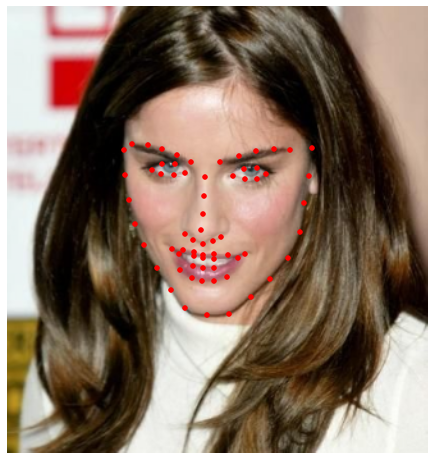

In [11]:
visualize_images(images)

In [ ]:
shapes = [i.landmarks['ibug_face_66'].lms for i in images]

Define correlation filter based sampler:

In [ ]:
def positive_class_sampler(images, shapes, patch_size=(16, 16), 
                           context_size=2, covariance=3, **kwargs):

    # check parameters
    context_size = check_context_size(context_size, patch_size)

    # extract patches
    patch_images = extract_patches(images, shapes, patch_size_context)

    # build desired response
    grid = build_grid(patch_size)
    response = multivariate_normal(mean=np.zeros(2), cov=covariance).pdf(grid)

    n_landmarks = shapes[0].n_points

    prefix = '- Training patch experts'
    patch_experts = []
    for j in print_progress(range(n_landmarks), prefix=prefix):

        samples = []
        for (i, s) in zip(images, shapes):
            # choose appropriate landmark
            centre = PointCloud([s.points[j]])
            # extract positive sample
            p = i.extract_patches(centre, patch_size=patch_size,
                                  as_single_array=True)[0, 0]
            
            # add positive sample to list
            samples.append(p)
        
        # turn list into ndarray
        samples = np.asarray(samples)

        # train patch experts
        patch_expert = patch_expert_cls(**kwargs).train(
            samples, response)

        # add patch expert to list
        patch_experts.append(patch_expert)

    return patch_experts

In [ ]:
patch_experts = build_lsvm_ensemble(
    images, 
    shapes, 
    patch_size=(16, 16), 
    context_size=2,
    C=100)

In [ ]:
filters = [pe.frequency_filter_image for pe in patch_experts]

In [ ]:
visualize_images(filters)

In [ ]:
i = images[0]
patch_experts[9].predict(i).view(cmap_name='jet')

In [ ]:
%timeit patch_experts[46].predict(i)

In [ ]:
from pyfftw.interfaces.numpy_fft import ifft2, fft2

In [ ]:
a = np.random.randn(8, 32, 32).astype(np.float32)
b = np.random.randn(66, 8, 32, 32).astype(np.complex64)

In [ ]:
%timeit c = ifft2(np.sum(fft2(a, threads=1).astype(np.complex64) * b, axis=1), threads=1)

In [ ]:
%timeit ifft2(sum(b, axis=1))


In [ ]:
c = ifft2(np.sum(fft2(a) * b, axis=1))
c.shape